# Model 3 Training Environment

This notebook contains the training environment for the third iteration of the signature verification siamse network. The previous version of the model was able to achieve aprox 25% validation accuracy. Improving upon model 1's 0% and inability to reach any level of convergence. The key imporvement in model 2 being the streamlining and simplification of the data wrangling before and dataloading during training. 

What I aim to do with model 3 is to adress that low accuracy using transfer learning. My suspicion about why the model is not converging beyond 25% is that the increase in complexity from digit matching with the mnist design to signature data has introduced new challenges to the task of image similarity checking. One of them being that there are significantly more classes. And what I mean by classes is not the model's binary training targets. I mean that of the images that belong in the dataset, there are now 70 unique train signatures as opposed to 10 unique types of digits for mnist. Signatures also have a lot more variability in terms of how the edges of the lines present in the image. I imagine model 2 was not complex enough (or perhaps it did have the capacity, itsd training process was not sophisticated enough) to first learn the ability to understand the edges and lines of the signatures, and then transition into understand what differentiates a persons signature based on the way those lines exist within the image. 

Using a model that was trained on the image net will alleviate the difficulty of the first part of the previous sentence. 

The Data wrangling has also been updated to have the distribution of classes between the test and train sets. Which wasn't the case originally.

## Outcome: 
The outcome of the changes made for model 3 is an improvement in val accuracy from 25% --> 31.7% 

## Next Steps:
Imrpovement is good but this is not a great performance. One difference in the way the model is failing to fully converge is that, now, the model is significantly overfitting. This is likely due to the use of the squeezenet and it's 1.2 million params. Squeezenet 1.1 was the lowest param transfer learning model I found that performed well on the imagenet. Moving into a more sophisticated imagenet trained model would likely just increase the overfitting. 

I still like the idea of using transfer learning, but want more control over the model. I am going to attempt to train an autoencoder on the signature data and implement the trained encoder in as the encoder of the siamese net. 

### Load in Dataset
Here I am loading in the data 

In [ ]:
import torch

-# load test_images.py test_labels.py train_images.py train_labels.py from cwd

test_images = torch.load('test_images.pt')
test_labels = torch.load('test_labels.pt')
train_images = torch.load('train_images.pt')
train_labels = torch.load('train_labels.pt')

In [32]:
print(f'test_images: {test_images.shape}')
print(f'test_labels: {test_labels.shape}\n')
print(f'train_images: {train_images.shape}')
print(f'train_labels: {train_labels.shape}')

test_images: torch.Size([254, 3, 224, 224])
test_labels: torch.Size([254])

train_images: torch.Size([885, 3, 224, 224])
train_labels: torch.Size([885])


### Load in Model

This is the adjusted model for the mnist

In [33]:
from model_3 import SiameseNet 

model = SiameseNet(input_shape = (1, 3, 224, 224),
                   embedding_size = 25,
                  similarity_function = "cosine similarity")

setting similarity function to cosine similarity


Below I am running a forward pass on a single example

In [34]:
print(f'test_images: {test_images.shape}')
print(f'test_labels: {test_labels.shape}\n')
print(f'train_images: {train_images.shape}')
print(f'train_labels: {train_labels.shape}')

test_images: torch.Size([254, 3, 224, 224])
test_labels: torch.Size([254])

train_images: torch.Size([885, 3, 224, 224])
train_labels: torch.Size([885])


Here I am running a forward pass to check the model works before starting training.

In [35]:
# extract two images
image_1 = train_images[4].unsqueeze(0)
image_2 = train_images[9].unsqueeze(0)

print(f'Image 1: {image_1.shape}')
print(f'Image 2: {image_2.shape}')

# extract two labels
label_1 = train_labels[0]
label_2 = train_labels[1]

# create target based on their similarity
target = [label_1 == label_2][0].float()

print(target)

# send model and images to device
print("checking device")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device found: {device}")

model = model.to(device)
print("model sent to device")
image_1 = image_1.to(device)
print("image 1 sent to device")
image_2 = image_2.to(device)
print("image 2 sent to deivce")

# forward pass
output = model(image_1, image_2)

print(f'output: {output.shape}')
print(f'output: {output}')

# compute prediction
prediction = torch.ge(output, 0.5).item()

print(f'prediction: {prediction} ----- target: {target}')


Image 1: torch.Size([1, 3, 224, 224])
Image 2: torch.Size([1, 3, 224, 224])
tensor(1.)
checking device
device found: cuda
model sent to device
image 1 sent to device
image 2 sent to deivce
output: torch.Size([1])
output: tensor([0.7299], device='cuda:0', grad_fn=<SigmoidBackward0>)
prediction: True ----- target: 1.0


In [36]:
# Count the number of trainable parameters
layer_params = [p.numel() for p in model.parameters() if p.requires_grad]

# print params at each layer
for i, p in enumerate(layer_params):
    print(f"Layer {i} has {p} parameters")

# sum parameters
print(f"\n Total number of trainable parameters: {sum(layer_params)}")

Layer 0 has 1728 parameters
Layer 1 has 64 parameters
Layer 2 has 1024 parameters
Layer 3 has 16 parameters
Layer 4 has 1024 parameters
Layer 5 has 64 parameters
Layer 6 has 9216 parameters
Layer 7 has 64 parameters
Layer 8 has 2048 parameters
Layer 9 has 16 parameters
Layer 10 has 1024 parameters
Layer 11 has 64 parameters
Layer 12 has 9216 parameters
Layer 13 has 64 parameters
Layer 14 has 4096 parameters
Layer 15 has 32 parameters
Layer 16 has 4096 parameters
Layer 17 has 128 parameters
Layer 18 has 36864 parameters
Layer 19 has 128 parameters
Layer 20 has 8192 parameters
Layer 21 has 32 parameters
Layer 22 has 4096 parameters
Layer 23 has 128 parameters
Layer 24 has 36864 parameters
Layer 25 has 128 parameters
Layer 26 has 12288 parameters
Layer 27 has 48 parameters
Layer 28 has 9216 parameters
Layer 29 has 192 parameters
Layer 30 has 82944 parameters
Layer 31 has 192 parameters
Layer 32 has 18432 parameters
Layer 33 has 48 parameters
Layer 34 has 9216 parameters
Layer 35 has 192 p

## Convert Data to Tensor Datasets and Wrap in Dataloader

In [37]:
from torch.utils.data import DataLoader, TensorDataset

# create train and test datasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# create train and test dataloaders
trainloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

## Load Training Environment

Here, I am setting up the Trainer class. I've set the epochs to 1000 and also turned off early stopping to gather an overabundance of data for the learning curves.

In [38]:
from train import Trainer
import torch.nn as nn

#set criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

#set epochs
epochs = 25000

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#set early stopping patience
patience = 100000

# create trainer instance
trainer = Trainer( model = model,
                   criterion = criterion, 
                   optimizer = optimizer, 
                   train_loader = trainloader, 
                   val_loader = testloader, 
                   epochs = epochs, 
                   device = device, 
                   early_stopping_patience = patience, 
                   batch_size=64)

Device: cuda


In [39]:
print(len(trainloader))
print(len(testloader))

14
4


Here I'm running the Trainer.

In [ ]:
import time

print("starting training...\n\n")

start = time.time()

best_model, val_loss, val_acc, train_loss, train_acc = trainer.train()    

end = time.time()

print(f"\nTraining time: {end - start}")

# 25 dimmensional vector embedding -- with cosine similarity. -- 2000 epochs -- batch size 32

In [22]:
max_val_accuracy = max(val_acc)
max_val_loss = max(val_loss)

max_train_accuracy = max(train_acc)
max_train_loss = max(train_loss)

print("highest val loss", max_val_loss)
print("highest train accuracy", max_val_accuracy)
print("highest train loss", max_train_loss)
print("highest train accuracy", max_train_accuracy)

highest val loss 0.29346901178359985
highest train accuracy 0.30952380952380953
highest train loss 0.6683107146195003
highest train accuracy 0.32924107142857145


# 10 dimmensional vector embedding -- with cosine similarity. -- 2000 epochs -- batch size 32

Matplotlib is building the font cache; this may take a moment.


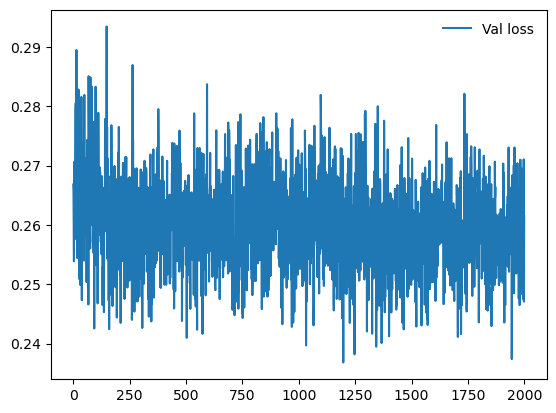

In [30]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(val_loss, label='Val loss')
#plt.plot(train_loss, label="Train loss")
plt.legend(frameon=False)


These plots show, although training did not go well, that the model and training method now have the capacity to learn/converge. 

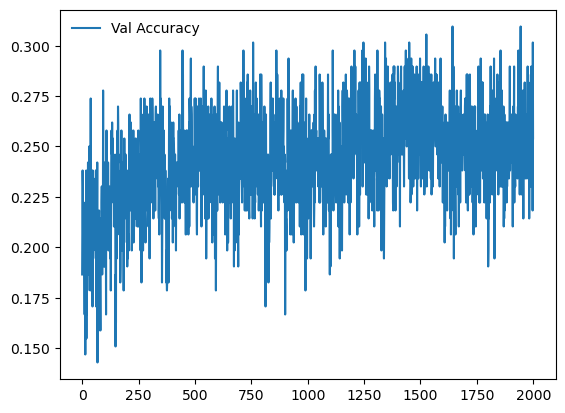

In [31]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(val_acc, label='Val Accuracy')
#plt.plot(train_acc, label="Train Accuracy")
plt.legend(frameon=False)

In [33]:
max_val_accuracy = max(val_acc)
max_val_loss = max(val_loss)

max_train_accuracy = max(train_acc)
max_train_loss = max(train_loss)

print("highest val loss", max_val_loss)
print("highest train accuracy", max_val_accuracy)
print("highest train loss", max_train_loss)
print("highest train accuracy", max_train_accuracy)

highest val loss 0.3161177486181259
highest train accuracy 0.31746031746031744
highest train loss 0.6886119331632342
highest train accuracy 0.6875


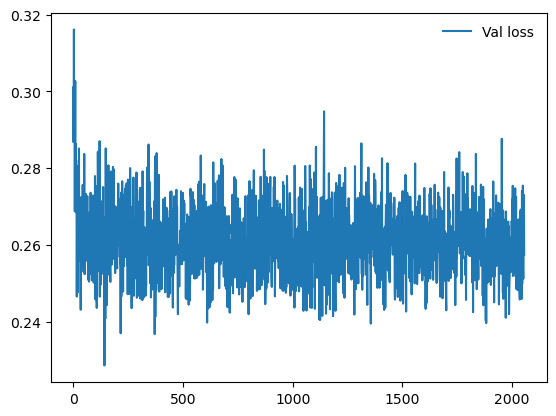

In [34]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(val_loss, label='Val loss')
#plt.plot(train_loss, label="Train loss")
plt.legend(frameon=False)


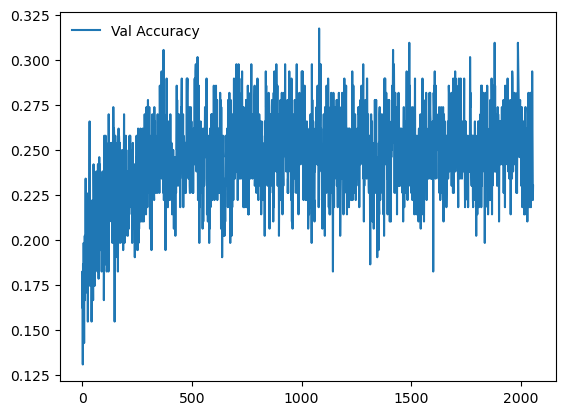

In [35]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(val_acc, label='Val Accuracy')
#plt.plot(train_acc, label="Train Accuracy")
plt.legend(frameon=False)